<a href="https://colab.research.google.com/github/felipemaiapolo/zelenskyy_speeches/blob/main/data_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analyses

## Setting-up

In [1]:
%%capture
!pip install --upgrade --force-reinstall numpy=='1.20.3' pandas=='1.3.3' wordcloud=='1.8.2.2' tqdm=='4.62.2' pingouin=='0.5.1' statsmodels=='0.13.0' scipy=='1.7.1' fsspec=='2022.5.0'

In [2]:
!mkdir plots

Loading packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy
from scipy import stats
from pingouin import qqplot
from wordcloud import WordCloud
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Defining important functions:

In [2]:
nlags=14

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

def wordcloud(text, colormap):
    return WordCloud(width=1000, height=1000, random_state=42, colormap=colormap, relative_scaling=0.5, collocations = False, background_color = 'white').generate(text) 

def plot_acf(acf_value, acf_interval, nlags, title, xlabel, ylabel):
    
    plt.axhline(y=0, lw=1.5, linestyle='-', alpha=.5)
    plt.scatter(x=range(nlags+1), y=acf_value)
    plt.vlines(x=range(nlags+1), ymin=0, ymax=acf_value, linewidth=1.5)
    plt.fill_between(x=range(1,nlags+1), y1=acf_interval[1:,0] - acf_value[1:], y2=acf_interval[1:, 1]-acf_value[1:], alpha=0.3, linewidth=0, color='lightblue')

    plt.ylabel(ylabel, size=14)
    plt.yticks(size=12)
    plt.ylim((-1.2,1.2))
    plt.xlabel(xlabel, size=14)
    plt.xticks(size=12)
    plt.grid(alpha=.2, axis='both')
    plt.axhline(y=0, color='r', lw=.5, linestyle='--', alpha=.5)
    plt.title(title, size=14)
    
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        np.round(dftest[0:4],2),
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

        
def plot1(data, title, ylabel, legend=None):
    plt.plot(data, '-', label=legend)
    plt.ylabel(ylabel, size=14)
    plt.yticks(size=12)
    plt.ylim((-4.5,4.5))
    plt.xticks(rotation=45, size=11)
    plt.grid(alpha=.2, axis='both')
    plt.axhline(y=0, color='r', lw=.75, linestyle='--', alpha=.2)
    plt.title(title, size=14)
    
    if legend!=None: plt.legend(bbox_to_anchor=(.98, .98), loc='upper right', borderaxespad=.0, framealpha=.25, ncol = 2)
    
def plot2(data, yerr, title, ylabel):
    plt.bar(x=data.index, height=data.values, yerr=yerr, capsize = 5)
    plt.ylabel(ylabel, size=14)
    plt.yticks(size=12)
    plt.xticks(rotation=45, size=11)
    plt.grid(alpha=.2, axis='both')
    plt.axhline(y=0, color='r', lw=.75, linestyle='--', alpha=.2)
    plt.title(title, size=14)
    
def plot3(ax, title):
    plt.plot(ax.get_lines()[0].get_data()[0],ax.get_lines()[0].get_data()[1], 'o')
    plt.plot(ax.get_lines()[1].get_data()[0],ax.get_lines()[1].get_data()[1], 'r-', lw=.5, alpha=1)
    plt.plot(ax.get_lines()[2].get_data()[0],ax.get_lines()[2].get_data()[1], 'r-', lw=.5, alpha=1)
    plt.plot(ax.get_lines()[3].get_data()[0],ax.get_lines()[3].get_data()[1], 'r--', lw=1.25, alpha=.75)
    plt.plot(ax.get_lines()[4].get_data()[0],ax.get_lines()[4].get_data()[1], 'r--', lw=1.25, alpha=.75)
    plt.ylabel('Empirical quantiles', size=14)
    plt.xlabel('Theoretical quantiles', size=14)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.grid(alpha=.2, axis='both')
    plt.title(title, size=14)
    plt.show()
    
def plot4(resid,predicted,ax):

    k=4
    plt.figure(figsize=(4*k,3.5*k))
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

    plt.subplot(3, 3, 1)
    plot1(resid, title="Residuals over time", ylabel='Residuals')

    plt.subplot(3, 3, 2)
    acf_value, acf_interval, _, _ = acf(resid,nlags=nlags,qstat=True,alpha=0.05, fft=False)
    plot_acf(acf_value, acf_interval, nlags=nlags, title="Residuals ACF", xlabel='Lags', ylabel='ACF')

    plt.subplot(3, 3, 3)
    acf_value, acf_interval = pacf(resid,nlags=nlags,alpha=0.05)
    plot_acf(acf_value, acf_interval, nlags=nlags, title="Residuals PACF", xlabel='Lags', ylabel='PACF')

    plt.subplot(3, 3, 4)
    plt.plot(predicted,resid, 'o')
    plt.ylabel('Residuals', size=14)
    plt.xlabel('Predicted', size=14)
    plt.yticks(size=12)
    plt.xticks(size=12)
    plt.grid(alpha=.2, axis='both')
    plt.title('Predicted Vs. Residuals', size=14)

    plt.subplot(3, 3, 5)
    plt.hist(resid, bins=15)
    plt.text(-3, 18, 'K-S pval={:.2f}\nS-W pval={:.2f}\nJ-B pval={:.2f}'.format(stats.kstest(resid, 'norm')[1], stats.shapiro(resid)[1], stats.jarque_bera(resid)[1]), fontsize=12)
    plt.xlabel('Residuals', size=14)
    plt.ylabel('Frequency', size=14)
    plt.yticks(size=12)
    plt.xticks(size=12)
    plt.grid(alpha=.2, axis='both')
    plt.title('Residuals histogram', size=14)

    plt.subplot(3, 3, 6)
    plot3(ax, title='Gaussian QQ-plot')
    plt.show()
   
    
def plot5(reg, feat, rotation=90):
    err=np.array(reg.beta_std)
    beta=np.array(reg.beta_mu)
    
    ind=np.argsort(beta)
    err=err[ind]
    beta=beta[ind]
    
    plt.errorbar([i for i in list(range(beta.shape[0]))],beta, yerr=err)
    plt.xticks([i for i in list(range(beta.shape[0]))],[(feat)[i] for i in ind], rotation=rotation)
    plt.axhline(y=0, color='r', linestyle='--', alpha=.5)
    
    plt.ylim(-1.1,.3)
    plt.ylabel('Estimates ($\pm$ std. dev.)')
    plt.grid(alpha=.2, axis='both')

def plot6(reg, feat):

  nr,nc=int((reg.beta.shape[1]+1)/3+.999),3
  k=6
  plt.figure(figsize=(2*k,.6*nr*k))
  plt.subplots_adjust(left, bottom, right, top, wspace, .5)

  for i in range(nr):
    for j in range(nc):
      if i*nc+j >= len(feat): 
        plt.subplot(nr, nc, i*nc+j+1)
        plot_hpd(reg.sigma2, title='$\sigma^2$')
        break
      else:
        plt.subplot(nr, nc, i*nc+j+1)
        plot_hpd(reg.beta[:,i*nc+j], title=feat[i*nc+j])
        plt.xlim(-1.2,1.2)
  plt.show()

In [20]:
### Adapted from https://github.com/tonyduan/conjugate-bayes
class NIGLinearRegression(object):
    """
    The normal inverse-gamma prior for a linear regression model with unknown
    variance and unknown relationship. Specifically,
        1/σ² ~ Γ(a, b)
        β ~ N(0, σ²V)
    Parameters
    ----------
    mu: prior for N(mu, v) on the model β
    v:  prior for N(mu, v) on the model β
    a:  prior for Γ(a, b) on the inverse sigma2 of the distribution
    b:  prior for Γ(a, b) on the inverse sigma2 of the distribution
    """
    def __init__(self, mu, v, a, b):
        self.__dict__.update({"mu": mu, "v": v, "a": a, "b": b})

    def fit(self, x_tr, y_tr):
        m, _ = x_tr.shape
        mu_ast = np.linalg.inv(np.linalg.inv(self.v) + x_tr.T @ x_tr) @ \
                 (np.linalg.inv(self.v) @ self.mu + x_tr.T @ y_tr)
        v_ast = np.linalg.inv(np.linalg.inv(self.v) + x_tr.T @ x_tr)
        a_ast = self.a + 0.5 * m
        b_ast = self.b + 0.5 * (y_tr - x_tr @ self.mu).T @ \
                np.linalg.inv(np.eye(m) + x_tr @ self.v @ x_tr.T) @ \
                (y_tr - x_tr @ self.mu.T)

        #double check
        self.b2=self.b + 0.5 * (self.mu.T@np.linalg.inv(self.v)@self.mu + y_tr@y_tr - mu_ast.T@np.linalg.inv(v_ast)@mu_ast)

        self.__dict__.update({"mu": mu_ast, "v": v_ast, "a": a_ast, "b": b_ast})

    def predict(self, x_te):
        scales = np.array([x.T @ self.v @ x for x in x_te]) + 1
        scales = (self.b / self.a * scales) ** 0.5
        return stats.t(df=2 * self.a, loc=x_te @ self.mu, scale=scales)

    def get_conditional_beta(self, sigma2):
        return stats.multivariate_normal(mean=self.mu, cov=sigma2 * self.v)

    def get_marginal_sigma2(self):
        return stats.invgamma(self.a, scale=self.b)

class LinReg(object):
    def __init__(self):
        pass

    def fit(self, X, y, m=5000):
        model = NIGLinearRegression(mu=np.zeros(X.shape[1]), v=1*np.eye(X.shape[1]), a=1, b=1)
        model.fit(X, y)
        self.model=model

        #Sampling from sigma2
        u=np.random.uniform(0,1,m)
        sigma2 = model.get_marginal_sigma2().ppf(u)

        #Sampling from beta
        beta = np.zeros((m,X.shape[1]))
        for i in range(m):
          beta_mu =   model.get_conditional_beta(sigma2=sigma2[i]).mean
          beta_cov =   model.get_conditional_beta(sigma2=sigma2[i]).cov
          beta[i] = np.random.multivariate_normal(beta_mu, beta_cov, 1)

        self.beta,self.sigma2=beta,sigma2
        self.beta_mu, self.beta_std, self.sigma2_mu, self.sigma2_std = np.mean(self.beta, axis=0), np.std(self.beta, axis=0), np.mean(self.sigma2, axis=0), np.std(self.sigma2, axis=0)
        self.resid=y-X@np.mean(self.beta, axis=0)

    def predict(self,X):
        return X@np.mean(self.beta, axis=0)

#HPD
def hpd(cde_estimates, bins_centers, gamma=.95):
    if not 0<gamma<1: raise ValueError("Parameter 'gamma' must be in interval (0,1).")
        
    hpd=[]
    n, n_grid=cde_estimates.shape
    bin_leng=bins_centers[1]-bins_centers[0]
        
    for i in range(n):

        probs=bin_leng*cde_estimates[i]

        for j in range(n_grid):
            ind=probs.argsort().argsort()>=(n_grid-j)
            if np.sum(ind*probs)>=gamma:
                break

        hpd.append(ind.tolist())

    return np.array(hpd)
    
def plot_cde(bins_centers, cde):
    bin_leng=bins_centers[1]-bins_centers[0]
    plt.bar(bins_centers, cde, width=bin_leng, alpha=.5)
    plt.xlabel('Parameter values', size=12)
    plt.ylabel('Density', size=12)
    
def plot_hpd(x, title, gamma=.9, bins=25):
    density,bins_edges=np.histogram(x, bins=bins)
    bin_leng=np.diff(bins_edges)[0]
    density=density/(np.sum(density)*bin_leng)
    bins_centers=bins_edges[:-1]+(bin_leng/2)
    indices=hpd(density.reshape((1,-1)), bins_centers, gamma).squeeze()
    plot_cde(bins_centers, (~indices)*density)
    plot_cde(bins_centers, (indices)*density)
    plt.title(title, size=14)
    plt.grid(alpha=.2, axis='both')
    #plt.title(title+" / HPD ({:.2f}%)".format(100*gamma))
    #plt.show()

## Processing speeches data

In [21]:
texts_sent = pd.read_csv('https://github.com/felipemaiapolo/zelenskyy_speeches/raw/main/data/texts_sent.csv')
texts_sent.date = pd.to_datetime(texts_sent.date).apply(lambda t: t.replace(tzinfo=None))
texts_sent.index=texts_sent.date
texts_sent = texts_sent.sort_index().loc['2022-02-24':]
texts_sent.head()

,date,title,text,url,sent
date,,,,,
2022-02-24 18:01:00,2022-02-24 18:01:00,Address by the President of Ukraine,Citizens of Ukraine. What do we hear today? It...,https://www.president.gov.ua/en/news/zvernenny...,0.156528
2022-02-25 01:10:00,2022-02-25 01:10:00,Address by the President to Ukrainians at the ...,Glory to the Armed Forces of Ukraine! Men and ...,https://www.president.gov.ua/en/news/zvernenny...,0.168868
2022-02-25 07:27:00,2022-02-25 07:27:00,Address by the President on the second morning...,The second morning of a large-scale war. At 4 ...,https://www.president.gov.ua/en/news/zvernenny...,0.145401
2022-02-25 13:07:00,2022-02-25 13:07:00,Address by the President of Ukraine,Chancellor of Germany Olaf Scholz yesterday sa...,https://www.president.gov.ua/en/news/zvernenny...,0.138623
2022-02-26 00:38:00,2022-02-26 00:38:00,Address by the President of Ukraine in the eve...,Today was a hard yet courageous day. We are fi...,https://www.president.gov.ua/en/news/zvernenny...,0.137573


### Descriptive analyses

In [22]:
sp = texts_sent.copy().sort_values('sent')
ind=[0,1,2,3,4,-1,-2,-3,-4,-5]

texts=list(sp.iloc[ind,:].text)
dates=list(sp.iloc[ind,:].date)
titles=list(sp.iloc[ind,:].title)

In [23]:
sp

,date,title,text,url,sent
date,,,,,
2022-06-04 23:17:00,2022-06-04 23:17:00,Russian army can stop killing if one person in...,"Ukrainians! All our defenders! On this day, th...",https://www.president.gov.ua/en/news/rosijska-...,0.076440
2022-05-08 09:05:00,2022-05-08 09:05:00,Address by the President of Ukraine on the Day...,Can spring be black and white? Is there eterna...,https://www.president.gov.ua/en/news/zvernenny...,0.093644
2022-03-04 11:21:00,2022-03-04 11:21:00,We have survived the night that could have sto...,People of Ukraine! We have survived the night ...,https://www.president.gov.ua/en/news/mi-perezh...,0.096442
2022-03-06 23:09:00,2022-03-06 23:09:00,The audacity of the aggressor is a clear signa...,Ukrainians! Today is Forgiveness Sunday. A day...,https://www.president.gov.ua/en/news/zuhvalist...,0.098874
2022-05-02 22:51:00,2022-05-02 22:51:00,The whole free world has united so that no one...,Ukrainians! Our defenders! The 68th day of our...,https://www.president.gov.ua/en/news/uves-viln...,0.100332
...,...,...,...,...,...
2022-06-17 21:32:00,2022-06-17 21:32:00,We managed to liberate Ukrainian paramedic Yul...,Ukrainians! All our defenders! We are now one ...,https://www.president.gov.ua/en/news/vdalosya-...,0.225536
2022-05-05 15:15:00,2022-05-05 15:15:00,Speech by President Volodymyr Zelenskyy at the...,Ladies and Gentlemen! After ten weeks of the f...,https://www.president.gov.ua/en/news/vistup-pr...,0.226521
2022-06-23 22:26:00,2022-06-23 22:26:00,This is the biggest step towards strengthening...,"Greetings to all our friends, all leaders-frie...",https://www.president.gov.ua/en/news/ce-najbil...,0.237490


Checking titles (some titles are not very clear because of the webscraping process -- we can still search them on Google):

In [24]:
titles

['Russian army can stop killing if one person in Moscow gives such an order, and the absence of such an order is a humiliation for the whole world - address by the President of Ukraine',
 'Address by the President of Ukraine on the Day of Remembrance and Reconciliation',
 'We have survived the night that could have stopped the history of Ukraine and Europe - address by President Volodymyr Zelenskyy',
 'The audacity of the aggressor is a clear signal that sanctions against Russia are not enough - President" s="" address\'="',
 'The whole free world has united so that no one justifies Nazism, kills children or destroys peaceful cities as Russia does - address by the President of Ukraine',
 'Political history always goes alongside economic one, and success can be common only - President Volodymyr Zelenskyy" s="" address="" to="" the="" participants="" of="" ukraine="" virtual="" investor="" conference\'="',
 'The Three Seas Initiative needs the potential of Ukraine - address by President 

Wordclouds:

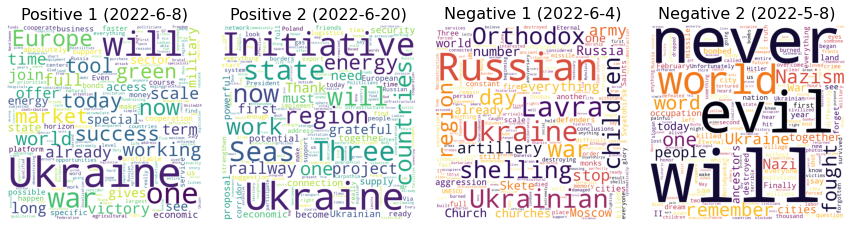

In [25]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(left, bottom, right, top, .1, .1)

colors=['viridis', 'viridis', 'inferno', 'inferno']
titles=['Positive 1','Positive 2','Negative 1','Negative 2']

inds=[-1,-2,0,1]
for i in range(4):
    plt.subplot(1, 4, i+1)
    wc=wordcloud(text=sp.iloc[inds[i],:].text, colormap=colors[i])
    plt.imshow(wc)
    plt.title(titles[i]+' ({:}-{:}-{:})'.format(sp.iloc[inds[i],:].date.year,sp.iloc[inds[i],:].date.month,sp.iloc[inds[i],:].date.day), size=16)
    plt.axis("off")

plt.savefig('plots/word_cloud.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

### Preparing data and doing extra analyses

Aggregating sentiment by day, interpolating NAs sentiments, and standardizing the data:

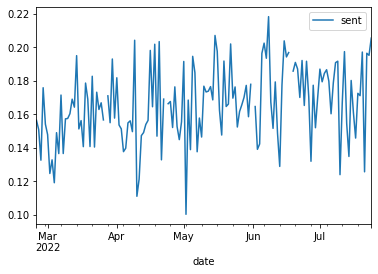

In [26]:
texts_sent = texts_sent.resample('D', on='date').agg({'sent' : 'mean'}) 
texts_sent.plot()
plt.show()

In [27]:
#Missing
mis=texts_sent.shape[0]-texts_sent.sent.count()
print('Number of days with no data: {:} ({:.2f}%)'.format(mis,100*mis/texts_sent.shape[0]))
texts_sent=texts_sent.interpolate()

#Std.
texts_sent['sent']=(texts_sent.sent-texts_sent.sent.mean())/texts_sent.sent.std()
texts_sent = pd.DataFrame(texts_sent.sent)

Number of days with no data: 4 (2.65%)


In [28]:
texts_sent.describe()

,sent
count,1.510000e+02
mean,3.293907e-16
std,1.000000e+00
min,-2.938741e+00
25%,-6.526143e-01
50%,1.846053e-02
75%,6.671208e-01
max,2.333238e+00


Calculating the first difference:

In [29]:
sent_diff=texts_sent.diff()
sent_diff.columns=['sent_diff']

In [30]:
sent_diff.describe()

,sent_diff
count,150.000000
mean,0.014612
std,1.320208
min,-4.161859
25%,-0.713210
50%,0.030590
75%,0.919083
max,3.161749


#### Testing for trends

##### Deterministic trends

Trend in $y_t$:

In [31]:
Y = np.array(texts_sent).squeeze()
X = sm.add_constant(np.array(range(texts_sent.shape[0])))
X.shape

(151, 2)

In [32]:
det1 = LinReg()
det1.fit(X,Y)

det1.beta_mu, det1.beta_std

(array([-0.57058559,  0.00767149]), array([0.15023394, 0.00175397]))

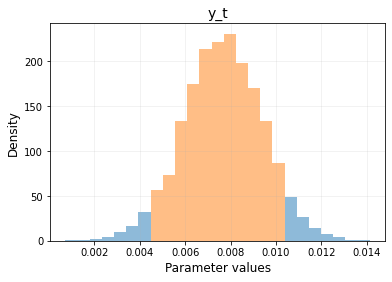

In [33]:
plot_hpd(det1.beta[:,1], title='y_t')

In [34]:
31*det1.beta_mu[1]

0.23781628833055887

In [35]:
%%capture
ax=qqplot(det1.resid)

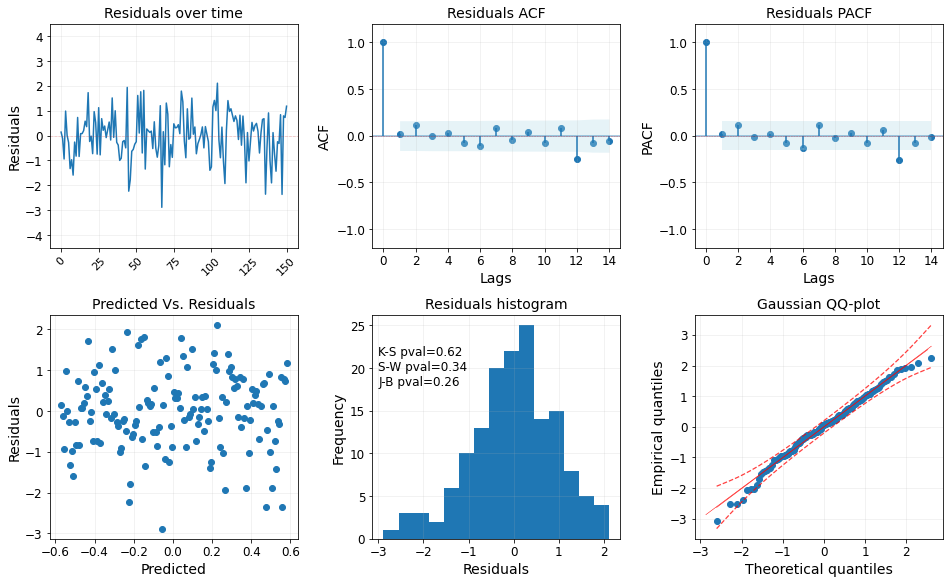

In [36]:
plot4(det1.resid, det1.predict(sm.add_constant(X)),ax)

In [87]:
det1.model.b, det1.model.b2

(67.3006617583332, 67.3006617587356)

Trend in $\Delta y_t$:

In [37]:
Y = np.array(sent_diff[1:]).squeeze()

In [38]:
det2 = LinReg()
det2.fit(X[1:],Y)

det2.beta_mu, det2.beta_std

(array([-0.01243103,  0.00038898]), array([0.21331649, 0.00246021]))

In [39]:
%%capture
ax=qqplot(det2.resid)

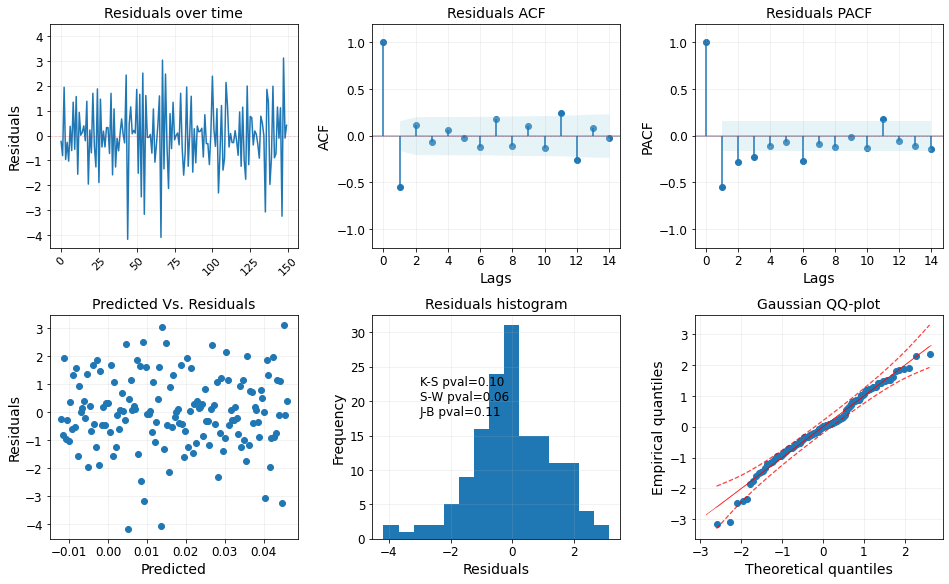

In [40]:
plot4(det2.resid, det2.predict(sm.add_constant(X[1:])), ax)

In [88]:
det2.model.b, det2.model.b2

(130.8317363248309, 130.8317363248283)

##### Stochastic trends

Trend in $y_t$:

In [41]:
adf_test(texts_sent)

Results of Dickey-Fuller Test:
Test Statistic                  -6.380000
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


Trend in $\Delta y_t$:

In [42]:
adf_test(sent_diff.iloc[1:])

Results of Dickey-Fuller Test:
Test Statistic                  -5.080000
p-value                          0.000000
#Lags Used                      13.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


### Plots

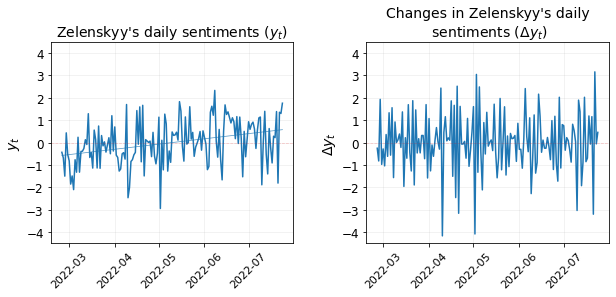

In [43]:
plt.figure(figsize=(10,3.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(1, 2, 1)
plot1(texts_sent, title="Zelenskyy's daily sentiments ($y_t$)", ylabel='$y_t$')
plt.plot(texts_sent.index, X[:,1]* det1.beta_mu[1] + det1.beta_mu[0], c='#1f77b4',lw=.75, alpha=.75)

plt.subplot(1, 2, 2)
plot1(sent_diff, title="Changes in Zelenskyy's daily\n sentiments ($\Delta y_t$)", ylabel='$\Delta y_t$')

plt.savefig('plots/plot1.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

Plotting ACF and PACF:

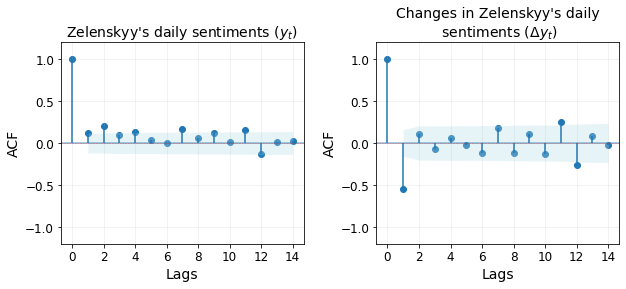

In [44]:
plt.figure(figsize=(10,3.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(1, 2, 1)
acf_value, acf_interval, _, _ = acf(texts_sent,nlags=nlags,qstat=True,alpha=0.15, fft=False)
plot_acf(acf_value, acf_interval, nlags=nlags, title="Zelenskyy's daily sentiments ($y_t$)", xlabel='Lags', ylabel='ACF')

plt.subplot(1, 2, 2)
acf_value, acf_interval, _, _ = acf(sent_diff.iloc[1:],nlags=nlags,qstat=True,alpha=0.05, fft=False)
plot_acf(acf_value, acf_interval, nlags=nlags, title="Changes in Zelenskyy's daily\n sentiments ($\Delta y_t$)", xlabel='Lags', ylabel='ACF')

plt.savefig('plots/plot_acf1.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

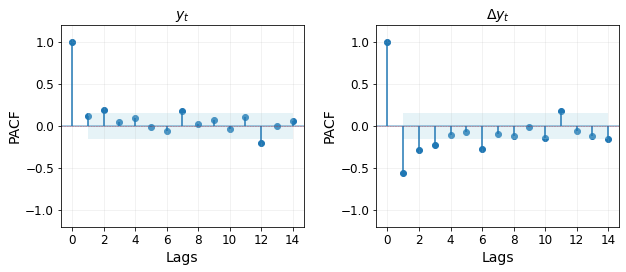

In [45]:
plt.figure(figsize=(10,3.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(1, 2, 1)
acf_value, acf_interval = pacf(texts_sent,nlags=nlags,alpha=0.05)
plot_acf(acf_value, acf_interval, nlags=nlags, title="$y_t$", xlabel='Lags', ylabel='PACF')

plt.subplot(1, 2, 2)
acf_value, acf_interval = pacf(sent_diff.iloc[1:],nlags=nlags,alpha=0.05)
plot_acf(acf_value, acf_interval, nlags=nlags, title="$\Delta y_t$", xlabel='Lags', ylabel='PACF')

plt.savefig('plots/plot_pacf1.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

Detrending $y_t$:

In [46]:
texts_sent.loc[:,'sent']=det1.resid
texts_sent['sent']=(texts_sent.sent-texts_sent.sent.mean())/texts_sent.sent.std()
texts_sent = pd.DataFrame(texts_sent.sent)

sent_diff=texts_sent.diff()
sent_diff.columns=['sent_diff']

## Preparing events data

Loading data:

In [47]:
%%time
ev = pd.read_csv('https://github.com/felipemaiapolo/zelenskyy_speeches/raw/main/data/events_dedup.csv')
ev.shape

CPU times: user 97 ms, sys: 5.57 ms, total: 103 ms
Wall time: 524 ms


(15647, 27)

Summing events per day and visualizing dataset:

In [48]:
ev.date=pd.to_datetime(ev.date, format='%Y%m%d')
ev = ev.resample('D', on='date').sum()
ev = ev.loc['2022-02-24':]
ev.head()

,longitude,latitude,t_mil_pred,t_loc_pred,t_san_pred,a_rus_pred,a_ukr_pred,a_civ_pred,a_other_pred,t_aad_pred,t_airstrike_pred,t_armor_pred,t_arrest_pred,t_artillery_pred,t_control_pred,t_killing_pred,t_firefight_pred,t_ied_pred,t_property_pred,t_raid_pred,t_occupy_pred,t_cyber_pred,t_hospital_pred,t_milcas_pred,t_civcas_pred,t_nmil_pred
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-24,4052.705582,5971.412508,109.857022,93.111370,18.136491,60.875789,47.450966,5.437861,1.427909,4.960525,11.338462,6.328168,11.011081,47.998466,12.635208,2.023776,22.241413,19.417735,23.982200,17.131920,8.281532,12.185710,7.974127,18.999871,31.491362,48.948861
2022-02-25,4950.493855,7298.343440,130.116384,121.401728,16.463197,67.950608,50.294150,5.085644,1.662628,5.543202,19.001246,11.806195,14.999995,62.999316,13.879248,4.356137,29.587904,11.637342,28.868063,19.488778,5.344244,9.625978,2.996981,12.995322,40.451224,59.727994
2022-02-26,4812.651585,7097.688480,125.494067,127.398139,17.314890,71.848212,40.725767,4.077661,3.467063,14.491798,36.999983,12.523128,16.915091,58.001552,10.027922,8.781244,23.091549,12.787675,26.989719,20.461472,0.308828,5.191870,7.999972,10.000585,35.681344,48.564390
2022-02-27,3609.816398,5344.261900,96.043107,92.152840,13.456695,52.533880,36.372552,5.139907,0.769223,1.802862,21.993399,10.415211,9.746614,40.000816,14.425043,8.115976,8.357317,8.451923,16.999841,12.803904,2.276302,5.964999,9.995680,18.032297,35.704232,44.187117
2022-02-28,4195.992044,6244.838853,110.959410,96.603806,16.439115,66.911337,39.552088,3.152320,0.444821,5.772468,26.998492,11.848148,10.935880,45.678894,16.003356,4.541267,13.717476,5.835996,18.998829,19.372843,1.301031,4.954696,6.001370,6.030555,30.077016,52.047545


Selecting columns:

In [49]:
events1=['a_rus_pred',
         'a_ukr_pred',
         'a_civ_pred',
         'a_other_pred']
events2=['t_mil_pred',
         't_nmil_pred']
events3=['t_aad_pred',
         't_airstrike_pred',
         't_armor_pred',
         't_arrest_pred',
         't_artillery_pred',
         't_civcas_pred',
         't_control_pred',
         't_cyber_pred',
         't_firefight_pred',
         't_hospital_pred',
         't_ied_pred', 
         't_milcas_pred',
         't_occupy_pred',
         't_property_pred',
         't_raid_pred']

events=events1+events2+events3
ev=ev.loc[:,events]
ev.shape

(152, 21)

In [50]:
ev.columns=['rus', 
            'ukr', 
            'civ', 
            'other', 
            'mil',
           'nmil', 
            'aad', 
            'airstrike', 
            'armor',
           'arrest', 
            'artillery',
            'civcas', 
            'control',
           'cyber', 
            'firefight',
            'hospital', 
            'ied',
           'milcas', 
            'occupy',
            'property',
            'raid']

events1=list(ev.columns[:4])
events2=list(ev.columns[4:6])
events3=list(ev.columns[6:])

Plotting:

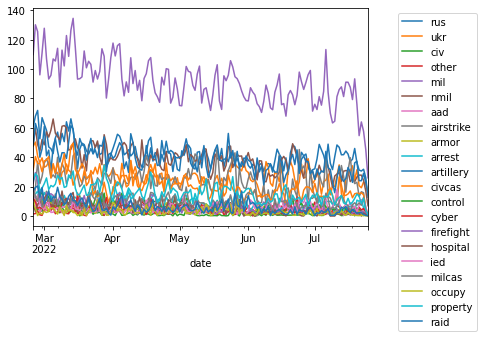

In [51]:
ev.plot()
plt.legend(bbox_to_anchor=(1.325, .98), loc='upper right', borderaxespad=.0)
plt.show()

Diff.:

In [52]:
ev=ev.diff().iloc[1:]

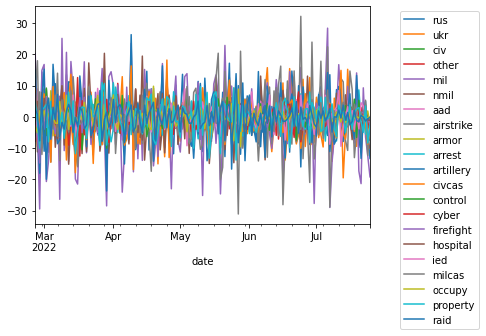

In [53]:
ev.plot()
plt.legend(bbox_to_anchor=(1.325, .98), loc='upper right', borderaxespad=.0)
plt.show()

ACFs and PACFs

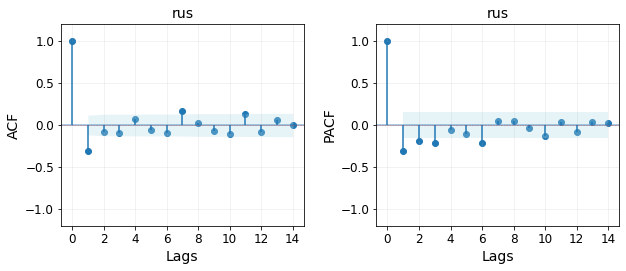

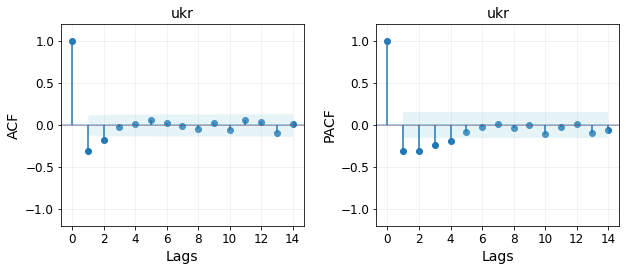

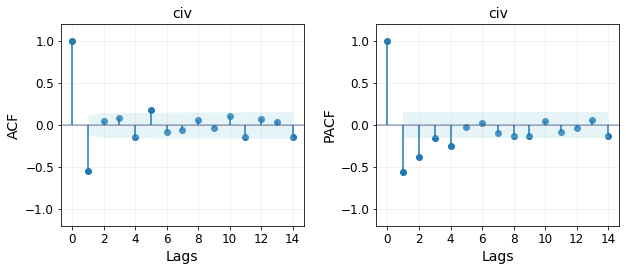

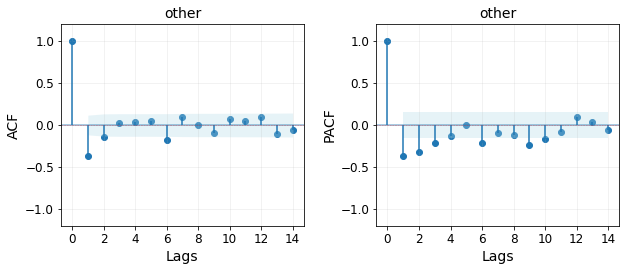

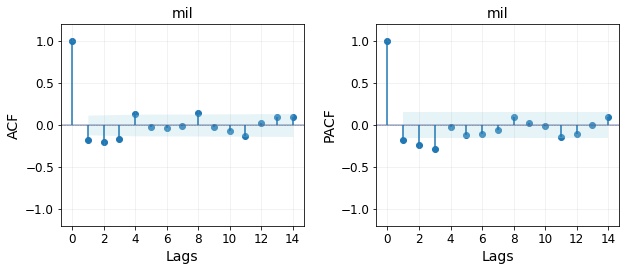

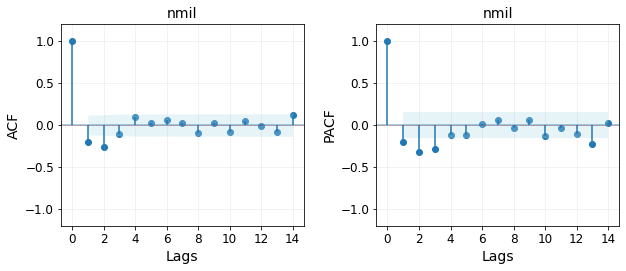

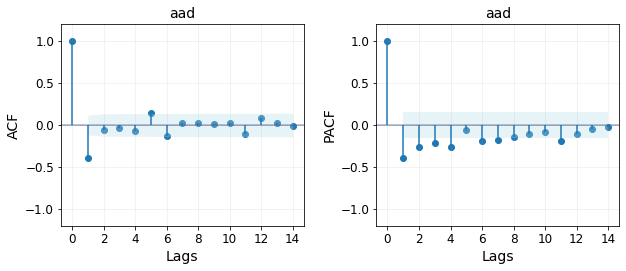

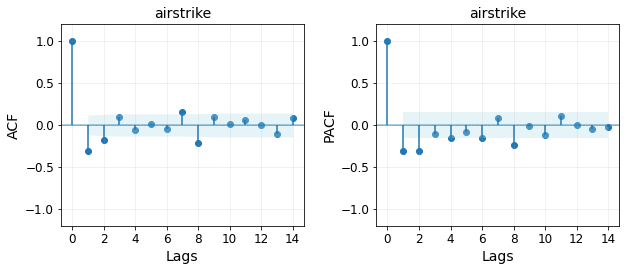

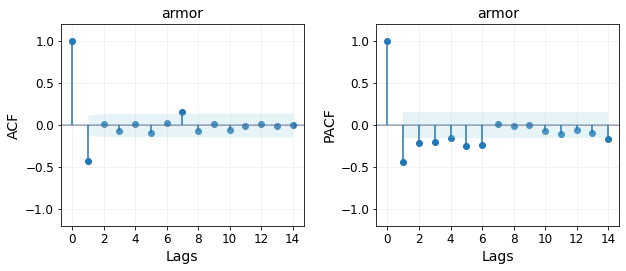

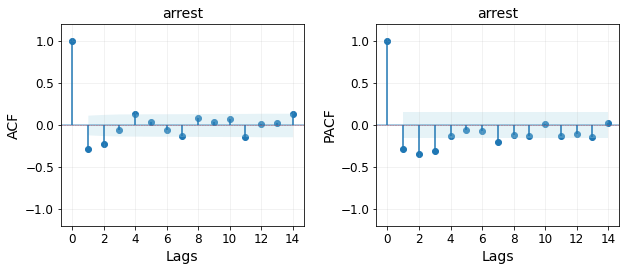

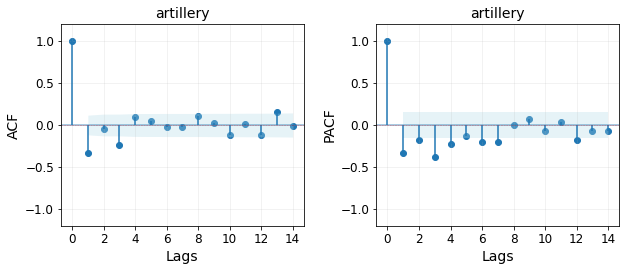

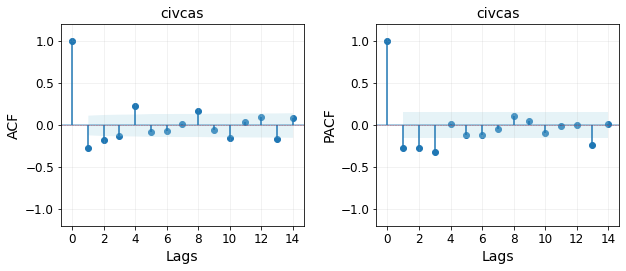

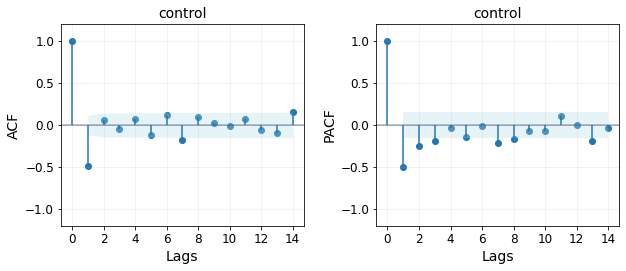

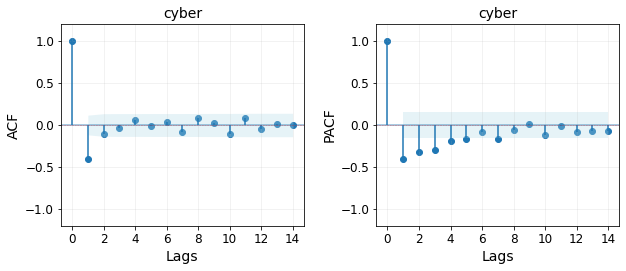

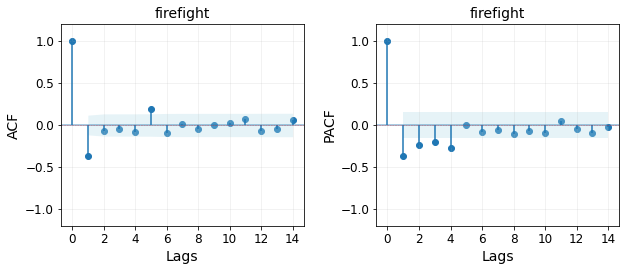

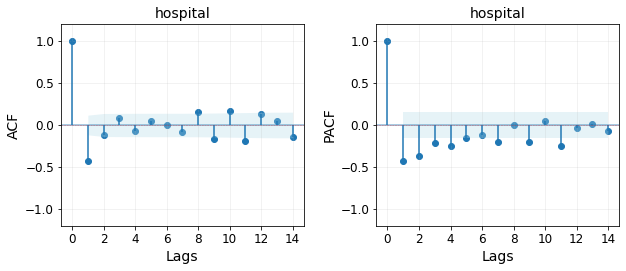

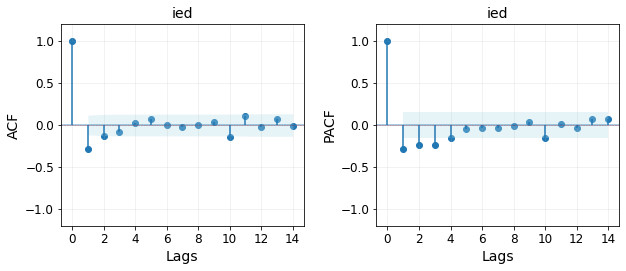

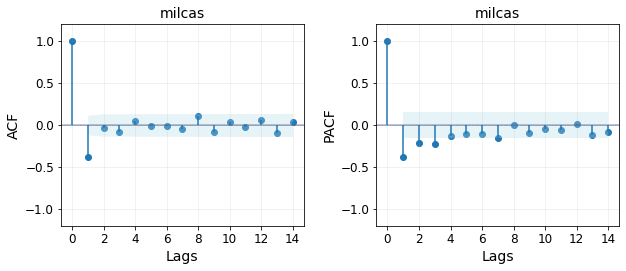

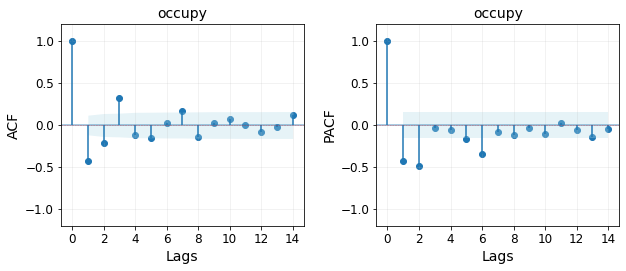

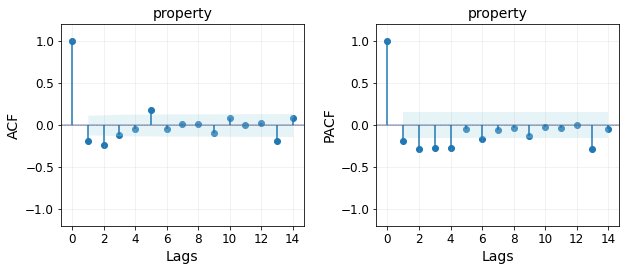

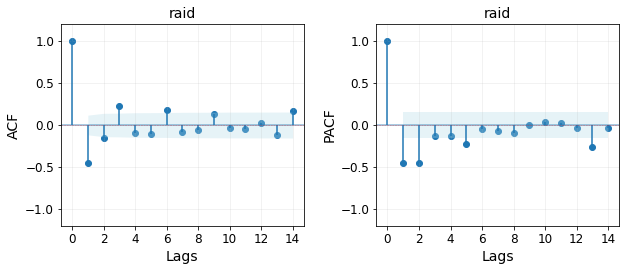

In [54]:
for j in range(ev.shape[1]):
  plt.figure(figsize=(10,3.5))
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

  plt.subplot(1, 2, 1)
  acf_value, acf_interval, _, _ = acf(ev.iloc[:,j],nlags=nlags,qstat=True,alpha=0.15, fft=False)
  plot_acf(acf_value, acf_interval, nlags=nlags, title=list(ev.columns)[j], xlabel='Lags', ylabel='ACF')

  plt.subplot(1, 2, 2)
  acf_value, acf_interval = pacf(ev.iloc[:,j],nlags=nlags,alpha=0.05)
  plot_acf(acf_value, acf_interval, nlags=nlags, title=list(ev.columns)[j], xlabel='Lags', ylabel='PACF')

  plt.show()


Series plots:


******************** rus ********************


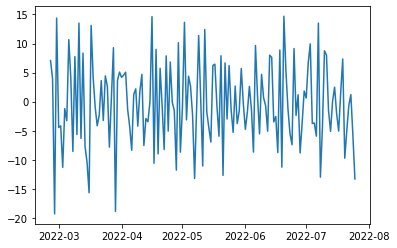


******************** ukr ********************


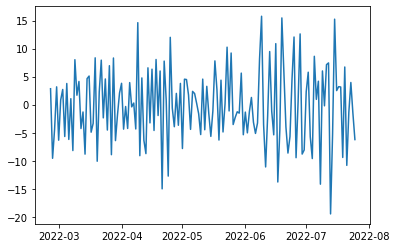


******************** civ ********************


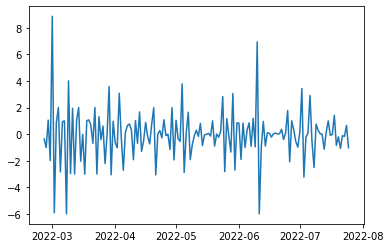


******************** other ********************


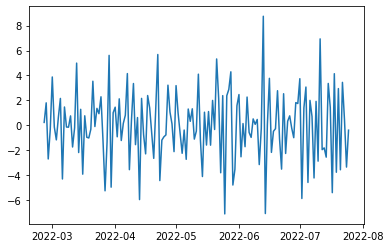


******************** mil ********************


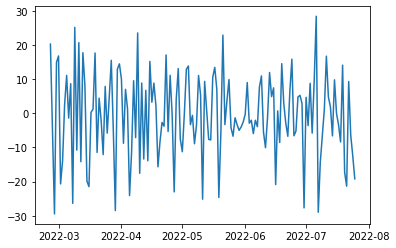


******************** nmil ********************


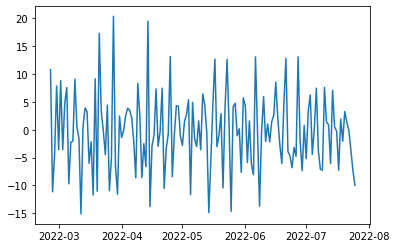


******************** aad ********************


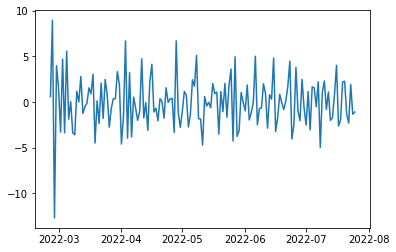


******************** airstrike ********************


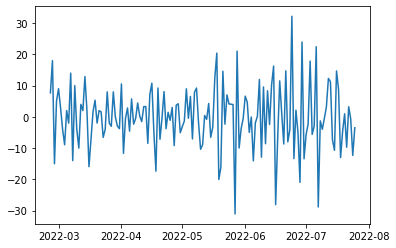


******************** armor ********************


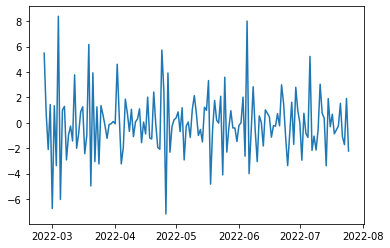


******************** arrest ********************


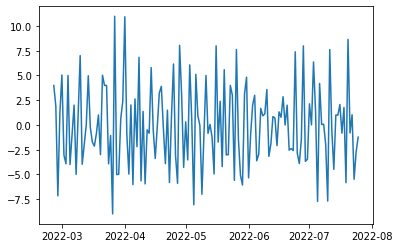


******************** artillery ********************


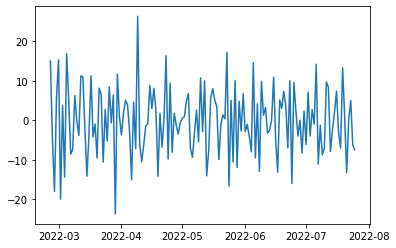


******************** civcas ********************


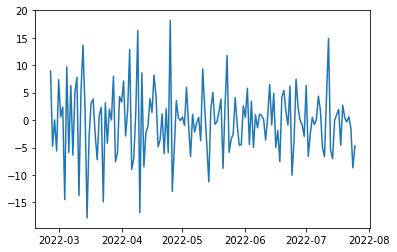


******************** control ********************


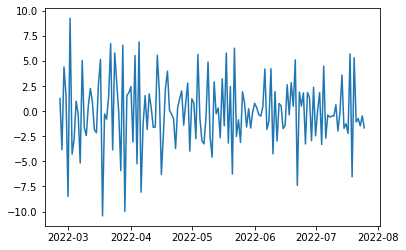


******************** cyber ********************


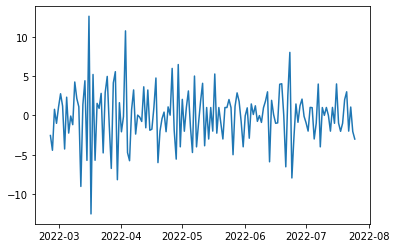


******************** firefight ********************


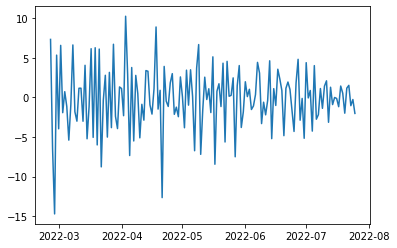


******************** hospital ********************


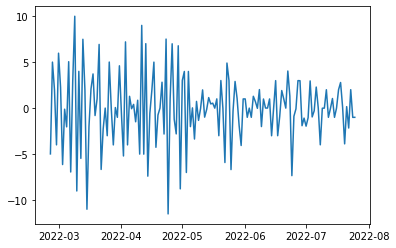


******************** ied ********************


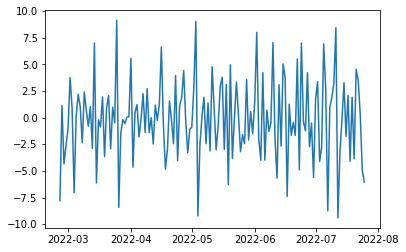


******************** milcas ********************


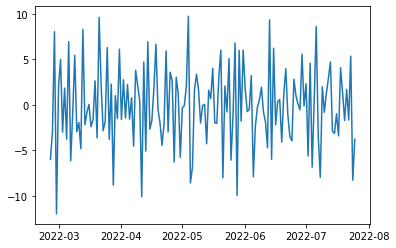


******************** occupy ********************


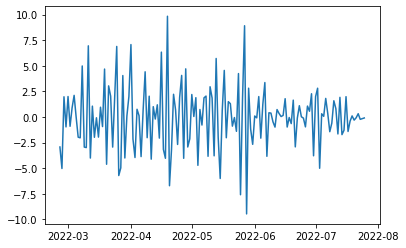


******************** property ********************


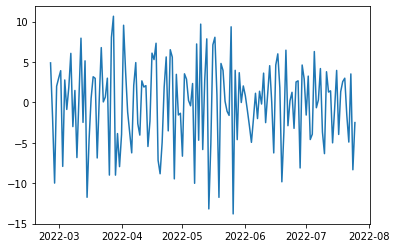


******************** raid ********************


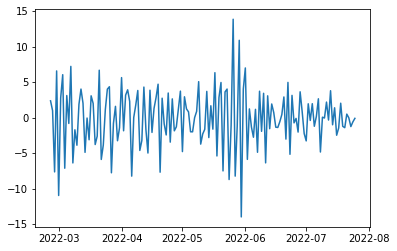

In [55]:
for j in range(ev.shape[1]):
  print("\n********************",list(ev.columns)[j],"********************")
  plt.plot(ev.iloc[:,j])
  plt.show()

Checking deterministic trends:

In [56]:
for j in range(ev.shape[1]):
  print("\n*************************************",list(ev.columns)[j],"*************************************")
  Y = ev.iloc[:,j]
  X = np.array(range(texts_sent.shape[0]))
  reg = sm.OLS(Y,sm.add_constant(X)).fit()
  print(reg.summary())


************************************* rus *************************************
                            OLS Regression Results                            
Dep. Variable:                    rus   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.04020
Date:                Tue, 16 Aug 2022   Prob (F-statistic):              0.841
Time:                        22:47:01   Log-Likelihood:                -511.38
No. Observations:                 151   AIC:                             1027.
Df Residuals:                     149   BIC:                             1033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

ADF tests

In [57]:
for j in range(ev.shape[1]):
  print("\n********************",list(ev.columns)[j],"********************")
  adf_test(ev.iloc[:,j])


******************** rus ********************
Results of Dickey-Fuller Test:
Test Statistic                  -8.130000
p-value                          0.000000
#Lags Used                       5.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64

******************** ukr ********************
Results of Dickey-Fuller Test:
Test Statistic                  -9.960000
p-value                          0.000000
#Lags Used                       3.000000
Number of Observations Used    147.000000
Critical Value (1%)             -3.475637
Critical Value (5%)             -2.881410
Critical Value (10%)            -2.577365
dtype: float64

******************** civ ********************
Results of Dickey-Fuller Test:
Test Statistic                 -10.360000
p-value                          0.000000
#Lags Used                       3.000000
Number of Observations

# Joining data

In [58]:
sent_diff.head()

,sent_diff
date,
2022-02-24,NaN
2022-02-25,-0.272672
2022-02-26,-0.877736
2022-02-27,2.049810
2022-02-28,-1.041678


In [59]:
sent_diff.shift(-1).head()

,sent_diff
date,
2022-02-24,-0.272672
2022-02-25,-0.877736
2022-02-26,2.049810
2022-02-27,-1.041678
2022-02-28,-0.306027


In [60]:
texts_sent.head()

,sent
date,
2022-02-24,0.154742
2022-02-25,-0.117931
2022-02-26,-0.995667
2022-02-27,1.054144
2022-02-28,0.012466


In [61]:
ev.head()

,rus,ukr,civ,other,mil,nmil,aad,airstrike,armor,arrest,artillery,civcas,control,cyber,firefight,hospital,ied,milcas,occupy,property,raid
date,,,,,,,,,,,,,,,,,,,,,
2022-02-25,7.074818,2.843184,-0.352218,0.234719,20.259362,10.779132,0.582678,7.662784,5.478027,3.988913,15.000850,8.959863,1.244040,-2.559733,7.346491,-4.977146,-7.780392,-6.004549,-2.937288,4.885863,2.356858
2022-02-26,3.897605,-9.568383,-1.007983,1.804436,-4.622316,-11.163604,8.948596,17.998738,0.716934,1.915096,-4.997764,-4.769880,-3.851327,-4.434108,-6.496355,5.002991,1.150332,-2.994736,-5.035416,-1.878344,0.972694
2022-02-27,-19.314333,-4.353215,1.062246,-2.697840,-29.450960,-4.377273,-12.688936,-15.006584,-2.107918,-7.168476,-18.000735,0.022888,4.397122,0.773129,-14.734232,1.995708,-4.335752,8.031712,1.967474,-9.989878,-7.657569
2022-02-28,14.377458,3.179536,-1.987587,-0.324403,14.916303,7.860429,3.969606,5.005093,1.432937,1.189266,5.678078,-5.627217,1.578313,-1.010303,5.360159,-3.994310,-2.615927,-12.001742,-0.975271,1.998988,6.568939
2022-03-01,-4.446054,-6.337974,8.873618,3.879722,16.787318,-3.593758,1.562101,9.001501,-6.750410,5.049545,15.286424,7.371416,-8.499073,1.059646,-3.962689,5.972777,-1.033454,1.965992,1.991246,2.996081,-10.980257


Joining:

In [62]:
data=sent_diff.shift(-1).join(texts_sent).join(ev)
data=data.iloc[1:-1] #Deleting NAs

Stdzing:

In [63]:
data.iloc[:,2:]=(data.iloc[:,2:]-data.iloc[:,2:].mean())/data.iloc[:,2:].std()

In [64]:
data.describe()

,sent_diff,sent,rus,ukr,civ,other,mil,nmil,aad,airstrike,armor,arrest,artillery,civcas,control,cyber,firefight,hospital,ied,milcas,occupy,property,raid
count,149.000000,149.000000,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02
mean,0.009271,-0.009518,2.831441e-17,8.941393e-18,-2.514767e-17,-3.353023e-17,1.862790e-17,-1.341209e-17,-2.533395e-17,8.941393e-18,4.470697e-18,1.192186e-17,4.470697e-18,-1.192186e-17,-1.117674e-17,-2.794185e-17,-2.980464e-18,5.960929e-18,1.192186e-17,-8.941393e-18,1.452976e-17,8.941393e-18,-3.427534e-17
std,1.410446,1.001237,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.440147,-3.064120,-2.680430e+00,-2.881947e+00,-3.091307e+00,-2.551758e+00,-2.378810e+00,-2.180825e+00,-4.514185e+00,-3.094126e+00,-2.941508e+00,-2.150295e+00,-2.743861e+00,-2.884647e+00,-2.999312e+00,-3.494841e+00,-3.678534e+00,-3.040391e+00,-2.524691e+00,-2.753191e+00,-3.046773e+00,-2.663195e+00,-3.362983e+00
25%,-0.770706,-0.587052,-6.709461e-01,-7.021294e-01,-4.431071e-01,-5.775437e-01,-5.219731e-01,-6.224494e-01,-6.575934e-01,-5.113624e-01,-4.776928e-01,-7.365344e-01,-7.008144e-01,-6.948163e-01,-6.027268e-01,-5.469092e-01,-5.196049e-01,-5.096694e-01,-6.529432e-01,-6.456509e-01,-6.390870e-01,-7.061780e-01,-5.325404e-01
50%,0.034072,0.063684,-7.940549e-02,-3.441986e-02,1.699323e-02,2.097327e-02,-8.178273e-03,-1.103658e-02,-9.384537e-03,-4.837481e-02,-3.959070e-02,-3.056130e-03,1.898718e-02,8.395227e-02,-2.778508e-02,2.247479e-02,6.052554e-02,1.074962e-02,-3.049115e-02,-1.917623e-02,3.059772e-02,1.285416e-01,1.598677e-02
75%,0.977466,0.622472,7.370836e-01,6.974363e-01,4.762433e-01,6.444980e-01,7.535989e-01,6.199738e-01,6.144707e-01,6.457695e-01,4.541019e-01,5.833012e-01,6.716376e-01,5.805455e-01,5.776816e-01,5.244524e-01,6.583642e-01,5.411511e-01,5.813072e-01,6.276607e-01,6.191370e-01,7.015770e-01,7.093342e-01
max,3.358788,2.247761,2.087076e+00,2.376098e+00,4.618227e+00,3.125385e+00,2.351227e+00,2.995540e+00,3.189496e+00,3.200944e+00,3.471157e+00,2.646114e+00,3.082103e+00,2.982136e+00,2.694978e+00,3.543330e+00,2.623611e+00,2.660355e+00,2.484359e+00,2.252378e+00,3.197518e+00,2.084042e+00,3.379293e+00


# Inference

In [65]:
data=data.rename(columns={"sent": "y_t"})

In [66]:
#data['t']=np.array(range(1,data.shape[0]+1))
data['intercept']=1

n,d=data.shape

### Simple model

In [67]:
feat0 =  ['intercept','y_t']
Y = np.array(data.sent_diff)
X = np.array(data.loc[:,feat0])

reg0 = LinReg()
reg0.fit(X,Y)
reg0.beta_mu, reg0.beta_std

(array([ 0.00153382, -0.97789587]), array([0.08409156, 0.08326878]))

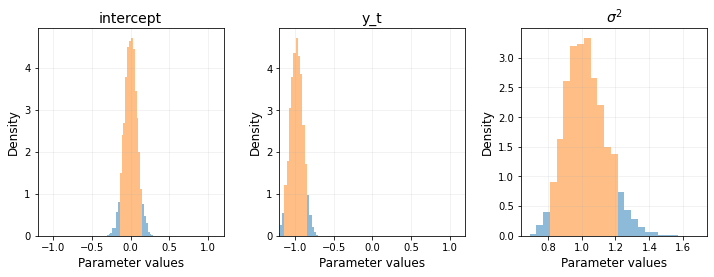

In [95]:
plot6(reg0,feat0)

In [69]:
%%capture
ax=qqplot(reg0.resid)

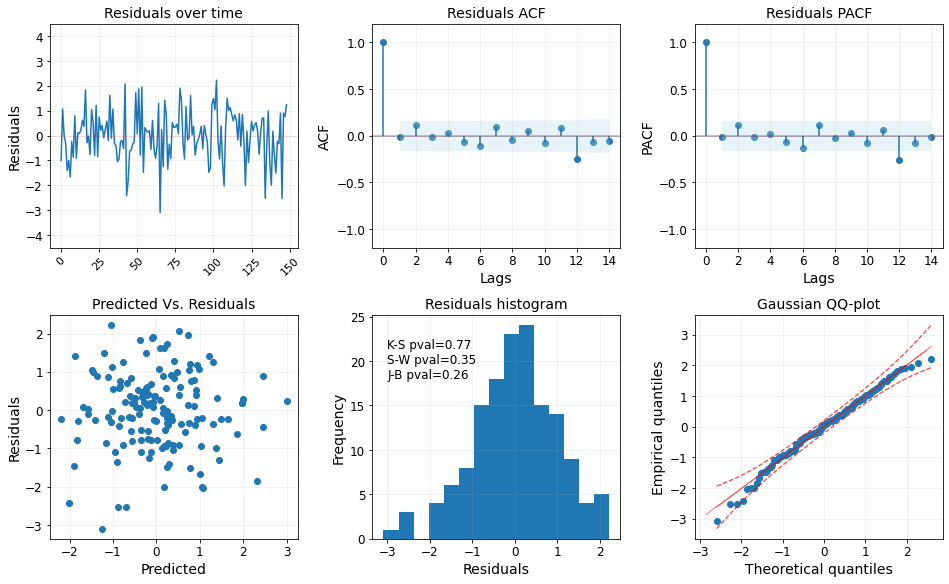

In [70]:
plot4(reg0.resid, reg0.predict(X), ax)

## Events 1

In [71]:
feat1 =  feat0 + events1
Y = np.array(data.sent_diff)
X = np.array(data.loc[:,feat1])

reg1 = LinReg()
reg1.fit(X,Y)
reg1.beta_mu, reg1.beta_std

(array([ 0.00119356, -0.95454326,  0.09314425, -0.18001444,  0.02565674,
        -0.05170048]),
 array([0.08099207, 0.0824085 , 0.08300598, 0.08395404, 0.08162446,
        0.08213635]))

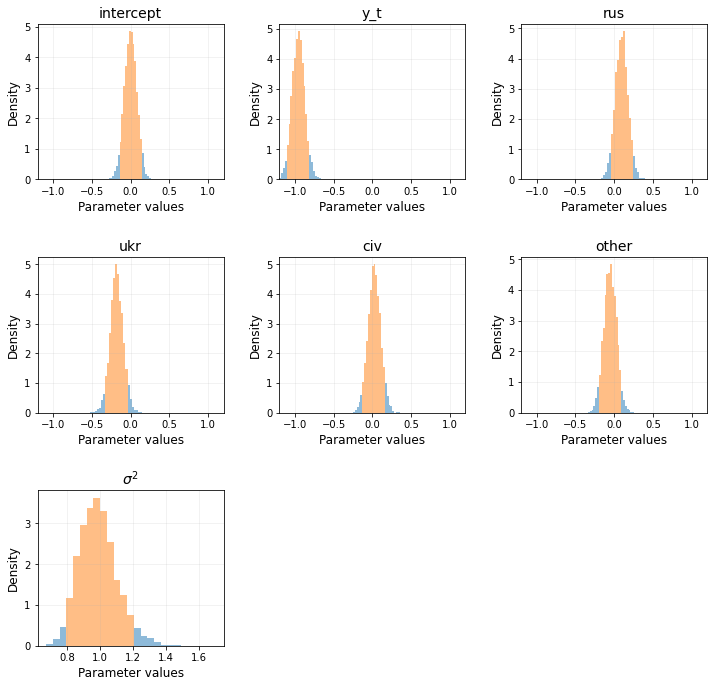

In [94]:
plot6(reg1,feat1)

In [73]:
%%capture
ax=qqplot(reg1.resid)

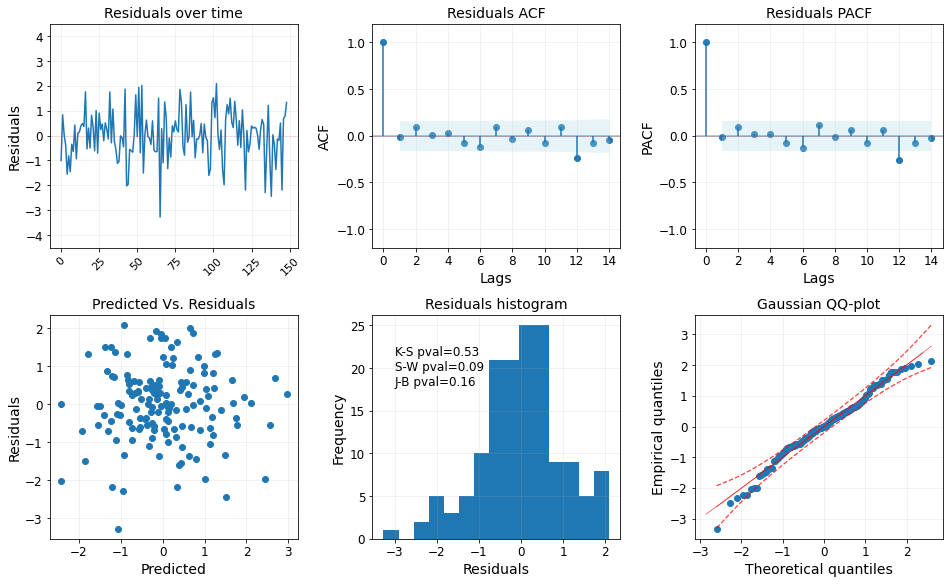

In [74]:
plot4(reg1.resid, reg1.predict(X), ax)

## Events 2

In [75]:
feat2 =  feat0 + events2
Y = np.array(data.sent_diff)
X = np.array(data.loc[:,feat2])

reg2 = LinReg()
reg2.fit(X,Y)
reg2.beta_mu, reg2.beta_std

(array([ 3.71691517e-04, -9.86295748e-01,  1.08190481e-02, -2.18885359e-01]),
 array([0.0805467 , 0.08004995, 0.08259276, 0.08180799]))

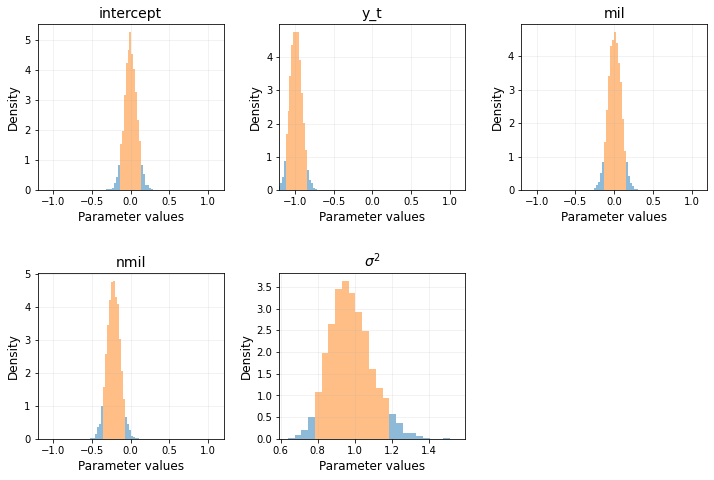

In [96]:
plot6(reg2,feat2)

In [77]:
%%capture
ax=qqplot(reg2.resid)

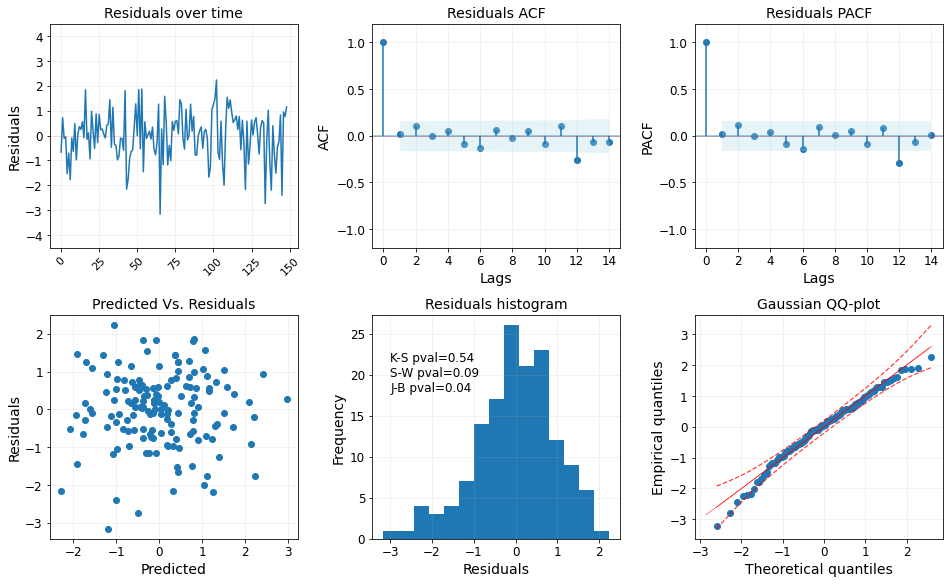

In [78]:
plot4(reg2.resid, reg2.predict(X), ax)

## Events 3

In [79]:
feat3 =  feat0 + events3
Y = np.array(data.sent_diff)
X = np.array(data.loc[:,feat3])

reg3 = LinReg()
reg3.fit(X,Y)
reg3.beta_mu, reg3.beta_std

(array([ 2.41256326e-04, -9.34296954e-01, -8.09173465e-02, -1.96339268e-02,
        -7.34002948e-02, -5.31535377e-03, -3.09414656e-02, -1.08628063e-01,
        -9.96303263e-03, -1.48193844e-01, -7.11264890e-02,  1.51503582e-01,
         4.73893107e-02, -2.10410142e-02, -1.19574396e-01,  1.03972602e-02,
         5.69817090e-02]),
 array([0.08005654, 0.08324931, 0.09041988, 0.08511576, 0.08429637,
        0.08480289, 0.09659972, 0.0958255 , 0.08616294, 0.08351795,
        0.0852975 , 0.08606444, 0.083387  , 0.08773837, 0.08763479,
        0.08885903, 0.08482318]))

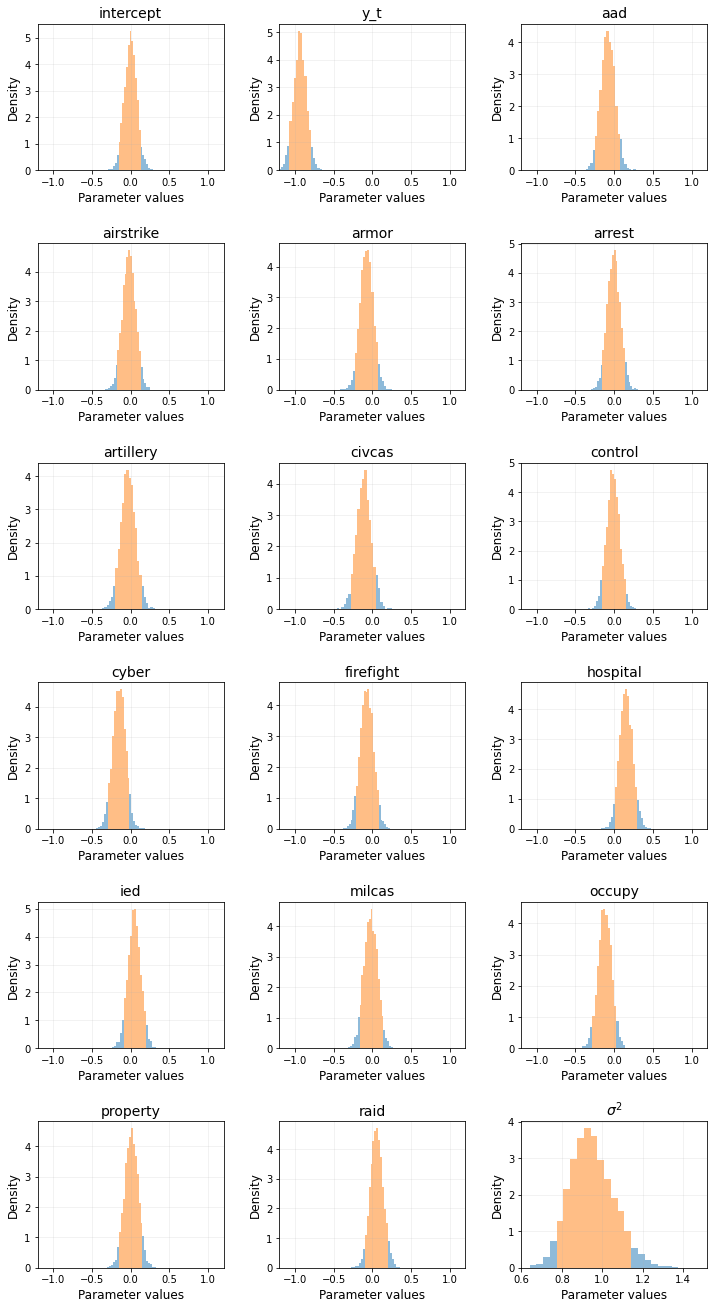

In [97]:
plot6(reg3,feat3)

In [81]:
%%capture
ax=qqplot(reg3.resid)

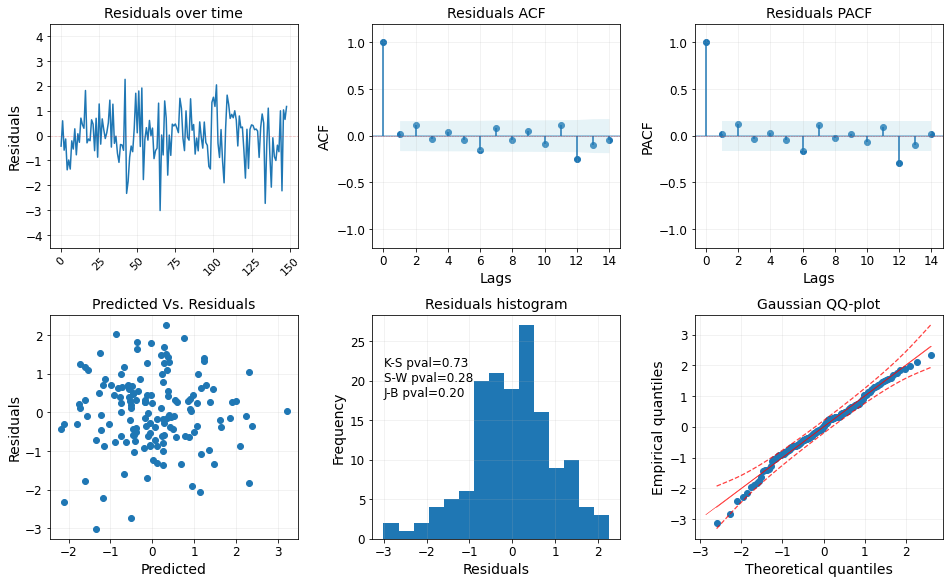

In [82]:
plot4(reg3.resid, reg3.predict(X), ax)

In [85]:
reg0.model.b, reg0.model.b2, reg1.model.b, reg1.model.b2, reg2.model.b, reg2.model.b2, reg3.model.b, reg3.model.b2

(76.45190346946022,
 76.45190346946023,
 73.5971136761498,
 73.59711367614975,
 72.88841642916728,
 72.88841642916725,
 70.70409083171525,
 70.70409083171529)

## Params

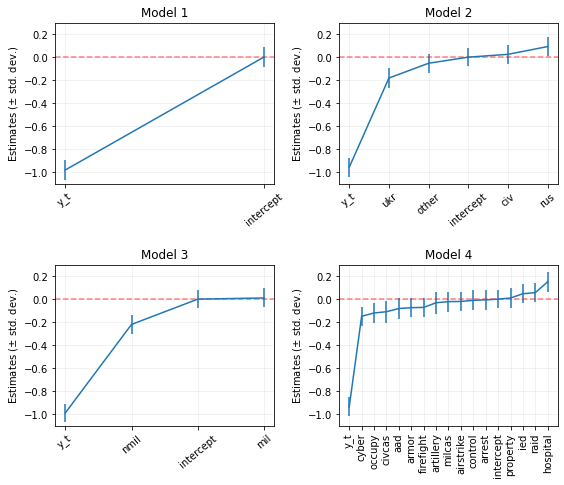

In [98]:
plt.figure(figsize=(9,7))
plt.subplots_adjust(left, bottom, right, top, wspace, .5)

plt.subplot(2, 2, 1)
plot5(reg0, feat0, rotation=40)
plt.title('Model 1')

plt.subplot(2, 2, 2)
plot5(reg1, feat1, rotation=40)
plt.title('Model 2')

plt.subplot(2, 2, 3)
plot5(reg2, feat2, rotation=40)
plt.title('Model 3')

plt.subplot(2, 2, 4)
plot5(reg3, feat3, rotation=90)
plt.title('Model 4')

plt.savefig('plots/estimates.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

# BF

In [99]:
from scipy import optimize

con = {'type': 'ineq', 'fun': lambda x: x[0]}

def f0(sigma2_beta):
  sigma2=sigma2_beta[0]
  beta=sigma2_beta[1:]
  return -reg0.model.get_marginal_sigma2().logpdf(sigma2) - reg0.model.get_conditional_beta(sigma2).logpdf(beta)

def f1(sigma2_beta):
  sigma2=sigma2_beta[0]
  beta=sigma2_beta[1:]
  return -reg1.model.get_marginal_sigma2().logpdf(sigma2) - reg1.model.get_conditional_beta(sigma2).logpdf(beta)

def f2(sigma2_beta):
  sigma2=sigma2_beta[0]
  beta=sigma2_beta[1:]
  return -reg2.model.get_marginal_sigma2().logpdf(sigma2) - reg2.model.get_conditional_beta(sigma2).logpdf(beta)

def f3(sigma2_beta):
  sigma2=sigma2_beta[0]
  beta=sigma2_beta[1:]
  return -reg3.model.get_marginal_sigma2().logpdf(sigma2) - reg3.model.get_conditional_beta(sigma2).logpdf(beta)

In [100]:
map0=optimize.minimize(f0, np.hstack((reg0.sigma2_mu, reg0.beta_mu)), constraints=con, method="cobyla").x
map1=optimize.minimize(f1, np.hstack((reg1.sigma2_mu, reg1.beta_mu)), constraints=con, method="cobyla").x
map2=optimize.minimize(f2, np.hstack((reg2.sigma2_mu, reg2.beta_mu)), constraints=con, method="cobyla").x
map3=optimize.minimize(f3, np.hstack((reg3.sigma2_mu, reg3.beta_mu)), constraints=con, method="cobyla").x

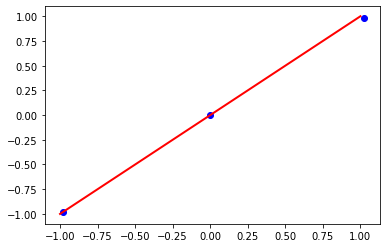

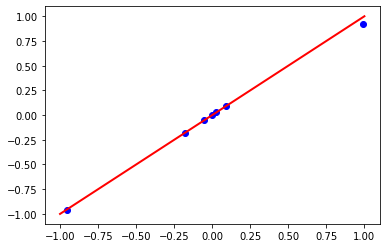

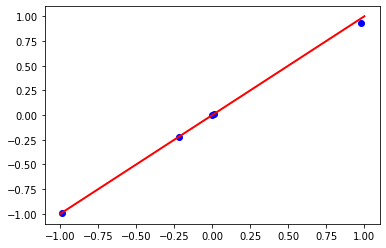

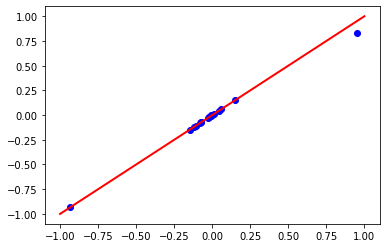

In [101]:
plt.plot(np.hstack((reg0.sigma2_mu, reg0.beta_mu)),map0,'bo')
plt.plot([-1, 1], [-1, 1], color = 'red', linewidth = 2)
plt.show()

plt.plot(np.hstack((reg1.sigma2_mu, reg1.beta_mu)),map1,'bo')
plt.plot([-1, 1], [-1, 1], color = 'red', linewidth = 2)
plt.show()

plt.plot(np.hstack((reg2.sigma2_mu, reg2.beta_mu)),map2,'bo')
plt.plot([-1, 1], [-1, 1], color = 'red', linewidth = 2)
plt.show()

plt.plot(np.hstack((reg3.sigma2_mu, reg3.beta_mu)),map3,'bo')
plt.plot([-1, 1], [-1, 1], color = 'red', linewidth = 2)
plt.show()

In [102]:
X = np.array(data.loc[:,feat0])
bic0=stats.norm.logpdf(Y, loc=X@map0[1:], scale=map0[0]**.5).sum() - .5*X.shape[1]*np.log(X.shape[0])

X = np.array(data.loc[:,feat1])
bic1=stats.norm.logpdf(Y, loc=X@map1[1:], scale=map1[0]**.5).sum() - .5*X.shape[1]*np.log(X.shape[0])

X = np.array(data.loc[:,feat2])
bic2=stats.norm.logpdf(Y, loc=X@map2[1:], scale=map2[0]**.5).sum() - .5*X.shape[1]*np.log(X.shape[0])

X = np.array(data.loc[:,feat3])
bic3=stats.norm.logpdf(Y, loc=X@map3[1:], scale=map3[0]**.5).sum() - .5*X.shape[1]*np.log(X.shape[0])

In [103]:
bic0, bic1, bic2, bic3 = np.round(bic0,3), np.round(bic1,3), np.round(bic2,3), np.round(bic3,3)

Z=np.exp(bic0)+np.exp(bic1)+np.exp(bic2)+np.exp(bic3)
p0,p1,p2,p3=np.round(np.exp(bic0)/Z,3), np.round(np.exp(bic1)/Z,3), np.round(np.exp(bic2)/Z,3), np.round(np.exp(bic3)/Z,3)

In [104]:
pd.DataFrame({'bic':[bic0, bic1, bic2, bic3], 'prob':[p0,p1,p2,p3]})

,bic,prob
0,-216.911,0.796
1,-224.089,0.001
2,-218.277,0.203
3,-248.952,0.000


# Prediction

In [105]:
train=.75

n_train=int(train*data.shape[0])
data_train=data.iloc[:n_train]
data_test=data.iloc[n_train:]

In [106]:
n_train, data.shape[0]-n_train

(111, 38)

### Individual events

In [107]:
feat={}

feat[0] = feat0
feat[1] = feat1
feat[2] = feat2
feat[3] = feat3

In [108]:
feat

{0: ['intercept', 'y_t'],
 1: ['intercept', 'y_t', 'rus', 'ukr', 'civ', 'other'],
 2: ['intercept', 'y_t', 'mil', 'nmil'],
 3: ['intercept',
  'y_t',
  'aad',
  'airstrike',
  'armor',
  'arrest',
  'artillery',
  'civcas',
  'control',
  'cyber',
  'firefight',
  'hospital',
  'ied',
  'milcas',
  'occupy',
  'property',
  'raid']}

Predictions:

In [109]:
results={}
dates=[]

for i in range(-1,4):
    results[i]=[]

for m in tqdm(range(n_train,data.shape[0])):
    data_train=data.iloc[:m]
    data_test=data.iloc[m:(m+1)]
    dates.append(data_test.index.date[0])

    for i in range(-1,4):

        if i==-1:
            results[i].append(data_test.sent_diff.values[0])
          
        else:
            Y_train = np.array(data_train.sent_diff)
            X_train = np.array(data_train.loc[:,feat[i]])

            reg = LinReg()
            reg.fit(X_train,Y_train,m=1000)

            X_test = np.array(data_test.loc[:,feat[i]])
            prediction=reg.predict(X_test[0:1,:])[0]
            results[i].append(prediction)
            
results=pd.DataFrame(results)

100%|██████████| 38/38 [02:41<00:00,  4.26s/it]


In [110]:
results.index=dates

In [111]:
results.columns=['y','m1','m2','m3','m4']

In [112]:
results

,y,m1,m2,m3,m4
2022-06-16,0.115504,-1.009920,-1.492045,-1.421584,-1.022896
2022-06-17,-0.271744,-1.100457,-0.671744,-1.187905,-0.802189
2022-06-18,-0.271744,-0.826948,-0.632782,-0.714440,-0.895545
2022-06-19,0.238957,-0.558653,-1.127263,-0.325553,-0.759608
2022-06-20,-0.194523,-0.773538,-0.958901,-0.961115,-0.801173
2022-06-21,-0.816160,-0.575818,-0.434705,-1.100608,-0.037978
2022-06-22,1.041111,0.201127,0.473311,0.358221,-0.058935
2022-06-23,-1.285167,-0.789409,-0.684292,-0.595523,-1.416846
2022-06-24,1.247317,0.443037,0.334280,0.694064,0.863072
2022-06-25,-1.018853,-0.759214,-1.050760,-0.623574,-0.321312


In [113]:
errors=results.copy()
for c in results.columns[1:]:
    errors[c]=(errors['y']-errors[c])

errors=errors.iloc[:,1:]

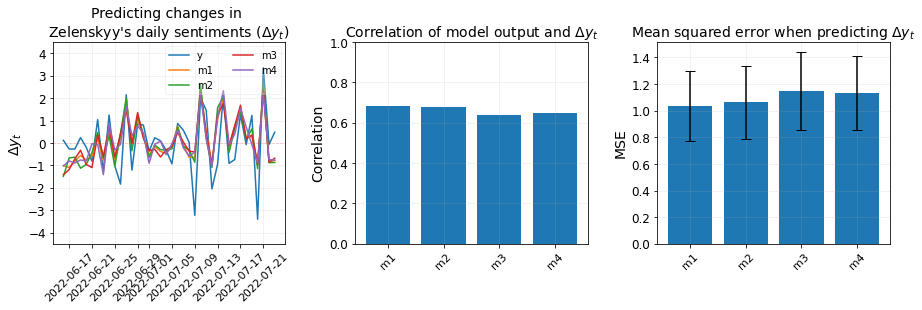

In [114]:
plt.figure(figsize=(15,3.5))
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

plt.subplot(1, 3, 1)
plot1(results, title="Predicting changes in \nZelenskyy's daily sentiments ($\Delta y_t$)", ylabel='$\Delta y_t$', legend=list(results.columns))

plt.subplot(1, 3, 2)
corr=results.corr().iloc[1:,0]
plot2(corr, yerr=None, ylabel='Correlation', title='Correlation of model output and $\Delta y_t$')
plt.ylim((0,1))

plt.subplot(1, 3, 3)
plot2((errors**2).mean(), yerr=np.sqrt(((errors**2).var()/errors.shape[0])), ylabel='MSE', title='Mean squared error when predicting $\Delta y_t$')

plt.savefig('plots/predictions.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()